[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 20 scenarios * 4 policies * 1 model(s) = 80 experiments
  1%|▌                                          | 1/80 [00:01<01:59,  1.51s/it]Traceback (most recent call last):
  File "/Users/marcpeterstreng/opt/miniconda3/envs/py39/lib/python3.9/site-packages/ema_workbench/em_framework/callbacks.py", line 246, in _store_outcomes
    self.results[outcome][case_id,] = outcome_res
KeyError: 'Dike Investment Costs'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/marcpeterstreng/opt/miniconda3/envs/py39/lib/python3.9/site-packages/ema_workbench/em_framework/ema_multiprocessing.py", line 253, in run
    self.callback(*result.get())
  File "/Users/marcpeterstreng/opt/miniconda3/envs/py39/lib/python3.9/site-packages/ema_workbench/em_framework/callbacks.py", line 281, in __call__
    self._store_outcomes(experiment.experiment_id, outcomes)
  File "/Users

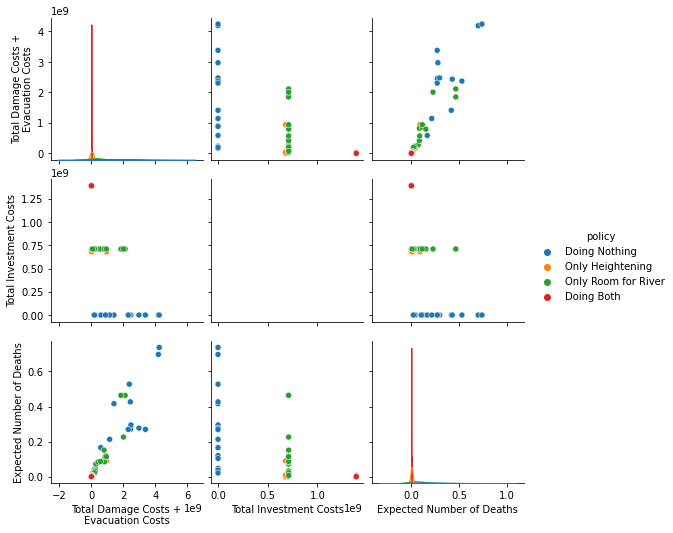

KeyError: 'Total Investment Costs'

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun  2 20:50:38 2021

@author: danie
"""

from __future__ import (unicode_literals, print_function, absolute_import,
                        division)
from ema_workbench import (MultiprocessingEvaluator, Policy, save_results)
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import time

if __name__ == '__main__':
    
    ema_logging.log_to_stderr(ema_logging.INFO)
    dike_model, planning_steps = get_model_for_problem_formulation(2)

#%%
    ###this defines policy 0, doing nothing
    # no dike increase, no warning, none of the rfr
    zero_policy = {'DaysToThreat': 2}
    zero_policy.update({'DikeIncrease {}'.format(n): 0 for n in planning_steps})
    zero_policy.update({'RfR {}'.format(n): 0 for n in planning_steps})
    
    pol0 = {}
    for key in dike_model.levers:
        s1, s2 = key.name.split('_')
        pol0.update({key.name: zero_policy[s2]})
        
#%%
    ###this defines policy 1 (heightening all dikes)
    heightening_policy = {'DaysToThreat': 2}
    heightening_policy.update({'DikeIncrease {}'.format(n): 5 for n in planning_steps})
    heightening_policy.update({'RfR {}'.format(n): 0 for n in planning_steps})
    
    pol1 = {}
    for key in dike_model.levers:
        s1, s2 = key.name.split('_')
        pol1.update({key.name: heightening_policy[s2]})

#%%   
    ###this defines policy 2 (only rfr in beginning)
    rfr_policy = {'DaysToThreat': 2}
    rfr_policy.update({'DikeIncrease {}'.format(n): 0 for n in planning_steps})
    rfr_policy.update({'RfR {}'.format(n): 
                       1 if n == 0 else 0 for n in planning_steps})
 
    pol2 = {}
    for key in dike_model.levers:
        s1, s2 = key.name.split('_')
        pol2.update({key.name: rfr_policy[s2]})

#%%
    #this defines policy 3 (a maximized approach)
    mixed_policy = {'DaysToThreat': 2}
    mixed_policy.update({'DikeIncrease {}'.format(n): 5 for n in planning_steps})
    mixed_policy.update({'RfR {}'.format(n):
                         1 if n == 0 else 0 for n in planning_steps})
    
    pol3 = {}
    for key in dike_model.levers:
        s1, s2 = key.name.split('_')
        pol3.update({key.name: mixed_policy[s2]})

#%%
    policy0 = Policy('Doing Nothing', **pol0)
    policy1 = Policy("Only Heightening", **pol1)
    policy2 = Policy("Only Room for River", **pol2)  
    policy3 = Policy('Doing Both', **pol3)
    policies = [policy0, policy1, policy2, policy3]
    n_policies = len(policies)
#%%
    n_scenarios = 20
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(
                                                scenarios = n_scenarios, 
                                                policies = policies
                                                )
    experiments, outcomes = results

#%% 
    outcomes['Total Investment Costs'] = (
        outcomes['Dike Investment Costs'] + outcomes['RfR Investment Costs'])
    
    outcomes['Total Damage Costs +\nEvacuation Costs'] = (
        outcomes['Expected Annual Damage'] + outcomes['Evacuation Costs'])
    
    
    b = experiments['policy'] 
    data = pd.DataFrame.from_dict(outcomes)
    data['policy'] = b
    data_to_show = [
                    'Total Damage Costs +\nEvacuation Costs', 
                    'Total Investment Costs',
                    'Expected Number of Deaths'
                    ]
    
    sns.pairplot(data, hue='policy',  vars=data_to_show)
    plt.show()
#%%
    #This section computes total costs and casualty condition
    dfoutcomes = pd.DataFrame(outcomes)
    dfoutcomes['Total costs'] = dfoutcomes.sum(axis=1)
    dfresults = pd.concat([experiments,dfoutcomes], axis=1)
    death_threshold = 0.0001
    y = outcomes['Expected Number of Deaths'] < 0.0001
    name = 'Death Risk Condition < {}'.format(str(death_threshold))
    dfresults[name] = y
    dfresults[name].value_counts()

    
    #this section saves the results to excel or tar if needed
    to_excel = False
    if to_excel == True:
        timestamp = time.strftime("%m.%d-%H%M%S")    
        dfresults.to_excel(r'.\results{}.xlsx'.format(timestamp), index = False)
        
    to_tar = True
    if to_tar == True:
        timestamp = time.strftime("%m.%d-%H%M%S")    
        fn = 'results/{} scenarios {} policies_{}.tar.gz'.format(n_scenarios, n_policies, timestamp)
        save_results(results, fn)
